In [ ]:
! pip install peewee reprobench seaborn numpy pandas

In [2]:
# db_path = "../output/sudoku-sat-2019.benchmark.db"
db_path = "/Users/rkkautsar/etc/sudoku-sat-2019.benchmark.db"

In [10]:
from playhouse.apsw_ext import APSWDatabase
from reprobench.core.db import db, Run, Tool, RunStatistic, ParameterCategory

database = APSWDatabase(db_path)
db.initialize(database)

In [11]:
from peewee import fn, Case, Window

def select_key(key):
    return (
        fn.MAX(Case(RunStatistic.key,
             (
                 (key, RunStatistic.value),
             ),
             None
        ))
#         .over(partition_by=[Run.id])
        .alias(key)
    )


query = (
    RunStatistic
    .select(
        Tool.name.concat('_').concat(ParameterCategory.title).alias('tool'),
        RunStatistic.run_id,
        select_key("cpu"),
        select_key("wall"),
        select_key("mem"),
    )
    .join(Run)
    .join(ParameterCategory)
    .switch(Run)
    .join(Tool)
    .where(Run.verdict == Run.SUCCESS)
    .group_by(RunStatistic.run_id)
)
summary = [d for d in query.dicts()]

In [12]:
import pandas as pd

df = pd.DataFrame(summary)
df = df.fillna(value=pd.np.nan)
df["cpu"] = df["cpu"].astype(float)
df["wall"] = df["wall"].astype(float)
df["mem"] = df["mem"].astype(float)

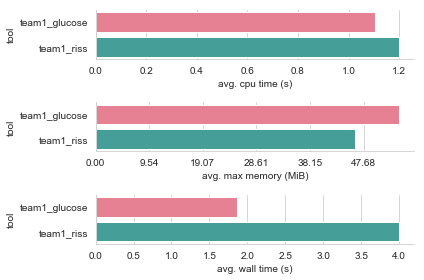

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
sns.set_style("whitegrid")

averages = df.groupby("tool")[["cpu", "mem", "wall"]].mean().reset_index()

def average_plot(measure, **kwargs):
    return sns.barplot(x=measure, y="tool", data=averages, palette="husl", **kwargs)

@ticker.FuncFormatter
def megabytes_formatter(x, pos):
    return f"{x / 1024. / 1024. :.2f}"

fig, axs = plt.subplots(nrows=3, sharey=True)
average_plot("cpu", ax=axs[0])
average_plot("mem", ax=axs[1])
average_plot("wall", ax=axs[2])
axs[1].xaxis.set_major_formatter(megabytes_formatter)
axs[1].xaxis.set_major_locator(ticker.AutoLocator())
axs[0].set_xlabel("avg. cpu time (s)")
axs[1].set_xlabel("avg. max memory (MiB)")
axs[2].set_xlabel("avg. wall time (s)")
sns.despine()
plt.tight_layout()
plt.show()

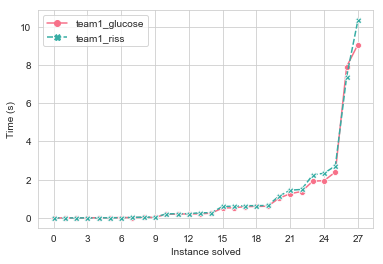

In [41]:
measure = 'cpu'
cactus_df = pd.DataFrame()
grouped_by_tool = (
    df
    [["tool", measure]]
    .groupby('tool')[measure]
    .apply(list)
)


for tool, values in grouped_by_tool.items():
    cactus_df = cactus_df.append(
        pd.DataFrame({ tool: sorted(values) }),
        sort=False
    )

plt.xticks()
plt.xlabel("Instance solved")
plt.ylabel("Time (s)")
fig = sns.lineplot(data=cactus_df, palette="husl", markers=True)
fig.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.show()